<h1> <a name="titel"></a>Gearbox Simulation Model</h1>

<p><b>Simulation of the vibration behaviour of a gearbox under degradation</b></p>

<img src="__pictures/Gearbox.png" width="60%">

<h1> <a name="intro"></a>Preliminary</h1>
<p> Load Modules </p>

In [1]:
# Build In
import os
from copy import deepcopy as dc
import sys
from IPython.display import display, HTML
# Third Party
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
# from gearbox_functions import gearbox_functions as gf
import gearbox_functions as gf

 <p>Define Directories</p>

In [2]:
wd = os.getcwd()
hdm = r'/Users/markhenss/Documents/GitHub/Gearbox' # mac directory
hdw = r'\\imapc\benutzer\Mitarbeiterdaten\henss\_02_software\_08_github\Gearbox' # win directory

<h1> <a name="motivation"></a>Motivation</h1>
<br>
<li>Gear Wheel Pitting</li>
<li>Degradation dominates at one tooth only</li>

<li>Operating Strategy [Gretzinger2017]</li>
<li>Local Stress reduction</li>

<h1> <a name="intro"></a>Introduction</h1>

<ul>
<li>Toolbox to simulate gearbox vibration</li>
<li>Virtual copy of an existing testbench</li>
  <ul>
    <li>Match on Vibration Spectra</li>
    <li>Match on Gear Degradation</li>
  </ul>
<li>No consideration of:</li>
  <ul>
    <li>Transmission paths formulation (Structure Borne Accoustics)</li>
    <li>Bearing Degradation (not seen in testbench)</li>
  </ul>
</ul>


<p>Acts as a state model:</p>

<ul>
    <li>Executes for a given load cycle (must be greater than the previous)</li>
    <li>Optional: Setting a new torque signal at the given load cycle (effecting the following load cycles)</li>
</ul>
<br>

<img src="__pictures/State_Definition.pdf" width="80%">



<p>General Input Arguments:</p>

<ul>
    <li>f<sub>i</sub>: Rotational Frequency input shaft - in revolutions per second (float)</li>
    <li>t<sub>i</sub>: Sample Interval - in seconds (float)</li>
    <li>f<sub>s</sub>: Sample Rate - in Hz (float)</li>
    <li>seed: Random Generator Seed (integer)</li>
</ul>

<p>Input Arguments <b>vibrations = model.run()</b>:</p>
<ul>
    <li>n<sub>lc</sub>: Current number of load cycle - in revolutions (float)</li>
</ul>

<p>Input Arguments <b>model.set()</b>:</p>
<ul>
    <li>n<sub>lc</sub>: Current number of load cycle - in revolutions (float)</li>
    <li><a href="torque">torque</a>: Input Torque - in Nm</li>
</ul>



<p><b>Output is calculated for previous given torque<sub>p-1</sub> argument.</b></p>
<p>Given Input Torque will be relevant in next time step n<sub>lc</sub></p>



<a name="torque"><h3>Torque</h3></a>

<p>Definition:</p>
<ul>
    <li>Must be defined as array</li>
    <li>Each value corresponds to a given time</li>
    <li>Function <u>'get_sample_time_torque()'</u> returns the time vector for torque</li>
    <li>Length of the torque vector must be at least as long as it takes for running once every possible meshing</li>

</ul>


<h1> <a name="modules"></a>Module Structure</h1>


<img src="__pictures/Modules.pdf" width="80%">



<ul>
    <li>GearBox Simulation Toolbox is structured in Modules</li>
    <li>Top Modules are accesing lower Modules</li>
    <li>Helper-Module is used by Modules on the same level</li>
    <li>Modules consisting of several Module Methods</li>
</ul>

<h1> <a name="intro"></a>Vibration</h1>

<p>Module Methods Structure:</p>

<img src="__pictures/Vibration_Method.pdf" width="100%">




<p>Required Inputs:</p>
<ul>
    <li>General Input Arguments (previous slides)</li>
    <li>Vibration Method Definition for each Element (see following slides)</li>
    <li>State of Degradation (given by degradation model)</li>
</ul>

<p>Outputs:</p>
<ul>
    <li>run(): Vibration Signal (for state s<sub>p</sub> = n<sub>lc</sub> based on previous torque<sub>p-1</sub>)</li>
    <li>set(): Loads per tooth/bearing (based on current torque<sub>p</sub>)</li>
</ul>

<a name="ElementMethod"><h3>Element Method</h3></a>

<ul>
    <li>Creating Base Signals for Bearing and Gear Elements</li>
    <li>Amplitude of +-1</li>
    <li>For Bearing choose any stationary signal: 'sine'</li>
    <li>For Gear choose any nonstationary signal: <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.gausspulse.html">'gausspulse'</a> <br>
</li>
</ul>

<p>Example Non-Stationary Sine Signal</p>

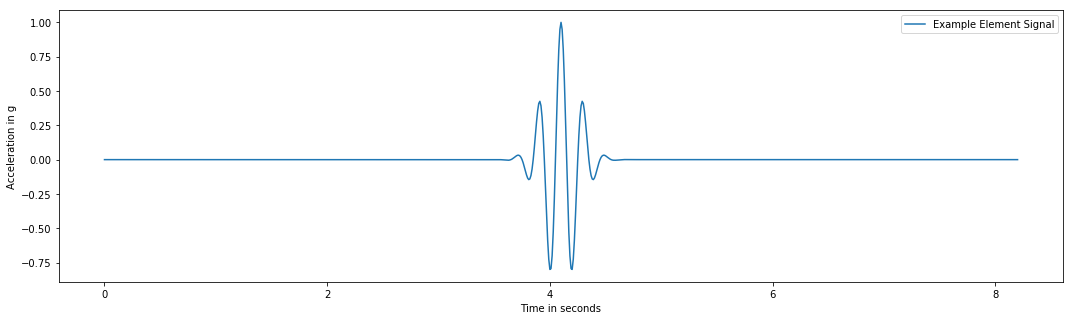

In [3]:
from scipy.signal import gausspulse
fi, fs = 5, 100
time_vector = gf.get_sample_time_torque(fi, fs, 21, 41)
element_signal = gausspulse(np.linspace(-max(time_vector)/2, max(time_vector)/2, time_vector.size), fc=fi, bw=0.5, bwr=-6, tpr=-60, retquad=False, retenv=False) # Nm | array
plt.figure(figsize=[18,5])
plt.plot(time_vector, element_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal'])
plt.show()

<p>Example Stationary Sine Signal</p>

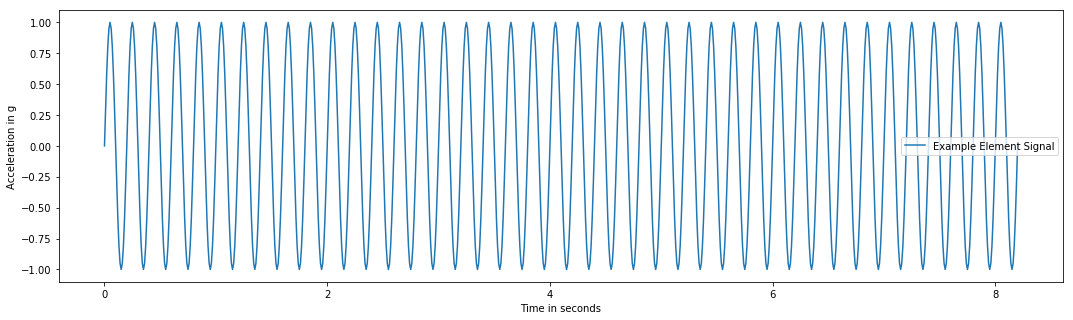

In [4]:
fi, fs = 5, 100
time_vector = gf.get_sample_time_torque(fi, fs, 21, 41)
element_signal = np.sin((2 * np.pi * fi * time_vector)) # Nm | array
plt.figure(figsize=[18,5])
plt.plot(time_vector, element_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal'])
plt.show()

<a name="AmplitudeMethod"><h3>Amplitude Method</h3></a>

<ul>
    <li>Scaling the Base Signals</li>
    <li>Various methods can be chosen (depending on Element)</li>
    <li>Depending on the chosen Method, different Attributes must be given</li>
    <li>'repeat' Methods create a pattern which will be repeated</li>
</ul>

<p>Methods:</p>
<ul>
    <li>None: Method not used</li>
    <li>'const': Constant Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'constant' (scalar))</li>
    <li>'const_repeat': Constant Amplitude for each tooth (list), and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'constant' (list, tuple))</li>
    <li>'gaussian': Gaussian Random Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>
    <li>'gaussian_repeat': Gaussian Random Amplitude for each tooth, and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>
</ul>

<p>Example Stationary Sine Signal * const Amplitude</p>

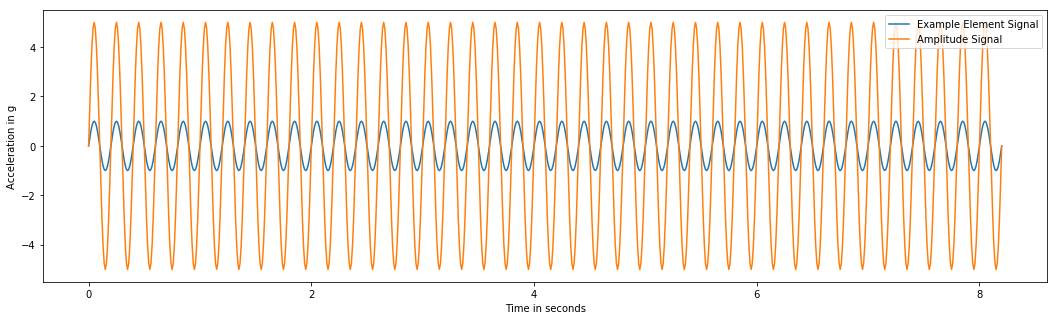

In [5]:
const = 5
amplitude_signal = element_signal * const
plt.figure(figsize=[18,5])
plt.plot(time_vector, element_signal, time_vector, amplitude_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal'])
plt.show()

<a name="NoiseMethod"><h3>Noise Method</h3></a>

<ul>
    <li>Adds noise to the signal</li>
    <li>Based on the Amplitude Methods Toolbox (repeat methods are not working)</li>
    <li>General use: Adding Gaussian Noise</li>
</ul>

<p>Methods:</p>

<ul>
    <li>None: Method not used</li>
    <li>'const': Constant Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'constant' (scalar))</li>
    <li><strike>'const_repeat': Constant Amplitude for each tooth (list), and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'constant' (list, tuple))</strike></li>
    <li>'gaussian': Gaussian Random Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>
    <li><strike>'gaussian_repeat': Gaussian Random Amplitude for each tooth, and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar))</strike></li>
</ul>

<p>Example Stationary Sine Signal * const Amplitude + noise</p>

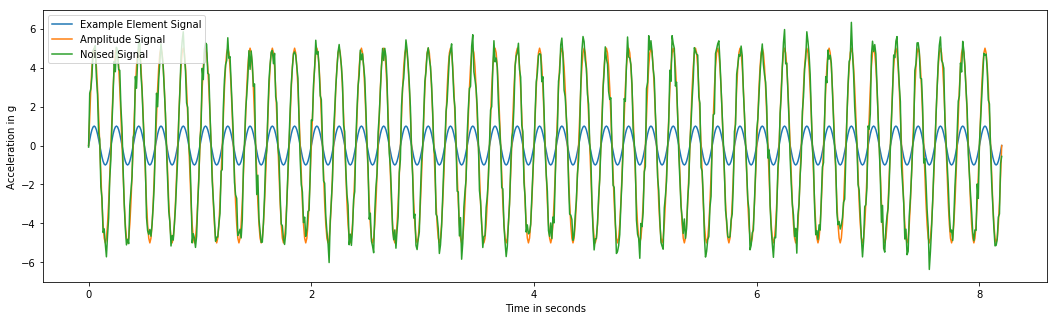

In [6]:
noise = np.random.randn(time_vector.size)*0.5
noised_signal = amplitude_signal + noise
plt.figure(figsize=[18,5])
plt.plot(time_vector, element_signal, time_vector, amplitude_signal, time_vector, noised_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal', 'Noised Signal'])
plt.show()

<a name="TorqueMethod"><h3>Torque Method</h3></a>

<ul>
    <li>Scales Signal s regarding the torque s<sub>t</sub></li>
    <li>1. s<sub>t</sub> = s<sub>t</sub>/s<sub>norm</sub>, norm signal by s<sub>norm</sub></li>
    <li>2. s<sub>t</sub> = f(s<sub>t</sub>), while f can be linear, polynomial and exponential</li>
    <li>3. s<sub>t</sub> = scale(s<sub>t</sub>), scale into range scale_min-scale_max while scale_min corresponds to value_min and scale_max to value_max</li>
    <li>4. s<sub>t</sub> = s<sub>t</sub> + 1, add one to retain origninal signal and add torque on top</li>
    <li>5. s = s * s<sub>t</sub></li>
</ul>

<p>Methods:</p>

<ul>
    <li>None: Method not used</li>
    <li>'linear': f in step 2 is linear transformation (no transformation)</li>
    <li>'polynomial': f in step 2 is polynomial with given exponent argument</li>
    <li>'exponential': f in step 2 is exponential</li>
</ul>

<p>Example Torque Signal 200 Nm +- 5 Nm</p>

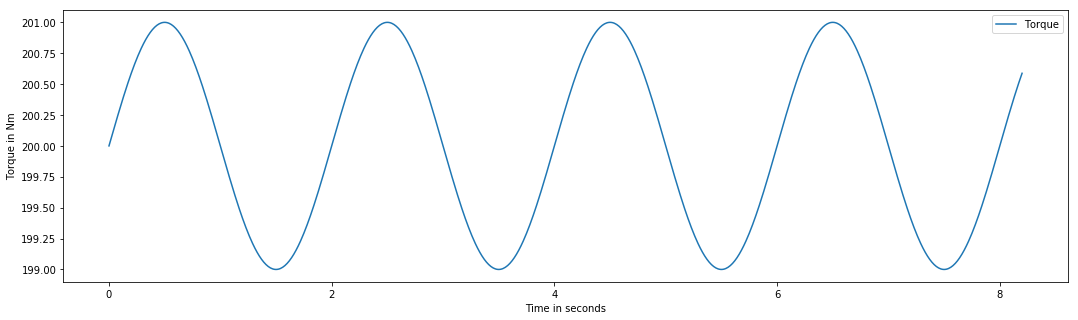

In [7]:
torque = np.sin((2 * np.pi * fi /10 * time_vector)) + 200 # Nm | array

plt.figure(figsize=[18,5])
plt.plot(time_vector, torque)
plt.xlabel('Time in seconds'), plt.ylabel('Torque in Nm'), plt.legend(['Torque'])
plt.show()


<p>Define Scale Arguments</p>

In [8]:
scale_min = 0                   
scale_max = 0.2
value_min = 1-0.01
value_max = 1.01
norm_divisor = 200
exponent = 2


<p>1. s<sub>t</sub> = s<sub>t</sub>/s<sub>norm</sub>, norm signal by s<sub>norm</sub></p>

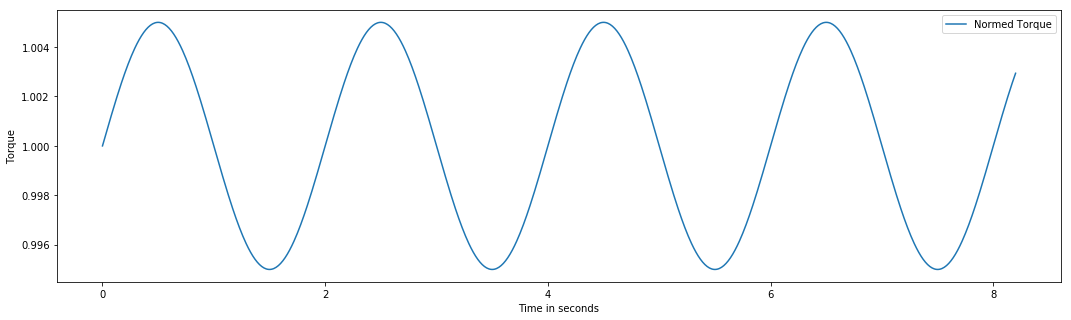

In [9]:
torque_1 = torque / norm_divisor

plt.figure(figsize=[18,5])
plt.plot(time_vector, torque_1)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque'])
plt.show()

<p>2. s<sub>t</sub> = f(s<sub>t</sub>), while f can be linear, polynomial and exponential</p>

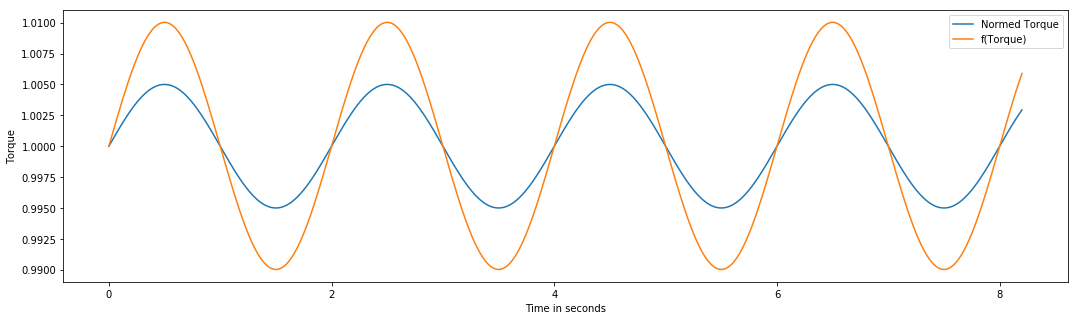

In [10]:
torque_2 = np.power(torque_1, exponent) 

plt.figure(figsize=[18,5])
plt.plot(time_vector, torque_1, time_vector, torque_2)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)'])
plt.show()

<p>3. s<sub>t</sub> = scale(s<sub>t</sub>), scale into range scale_min-scale_max while scale_min corresponds to value_min and scale_max to value_max</p>

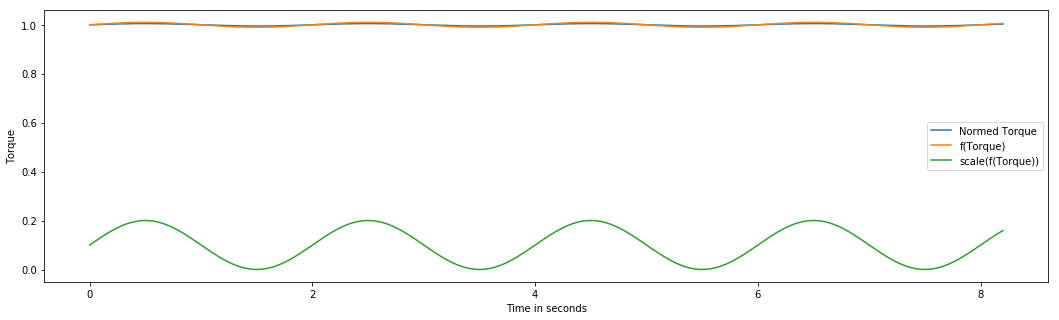

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
scaler.fit(np.array([value_min, value_max]).reshape(-1, 1))
torque_3 = scaler.transform(torque_2.reshape(-1, 1)) 

plt.figure(figsize=[18,5])
plt.plot(time_vector, torque_1, time_vector, torque_2, time_vector, torque_3)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)', 'scale(f(Torque))'])
plt.show()

<p>4. s<sub>t</sub> = s<sub>t</sub> + 1, add one to retain origninal signal and add torque on top</p>

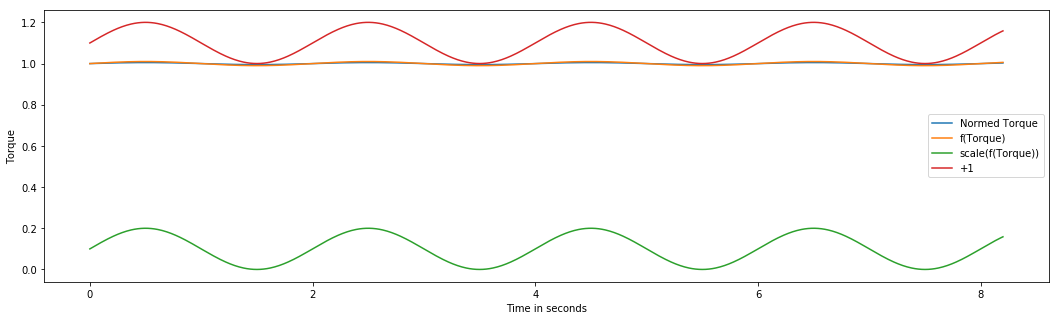

In [12]:
torque_4 = torque_3 + 1 

plt.figure(figsize=[18,5])
plt.plot(time_vector, torque_1, time_vector, torque_2, time_vector, torque_3, time_vector, torque_4)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)', 'scale(f(Torque))', '+1'])
plt.show()

<p>5. s = s * s<sub>t</sub></p>
<p>(Example Stationary Sine Signal * const Amplitude + noise) * Torque</p>

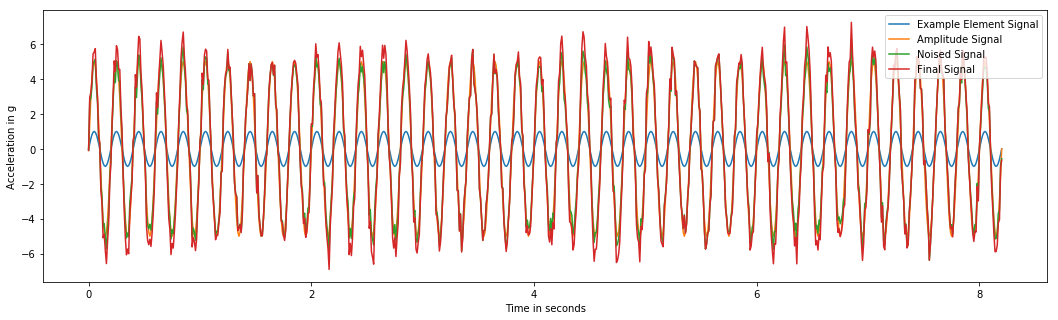

In [13]:
final_signal = noised_signal * torque_4.reshape(-1)

plt.figure(figsize=[18,5])
plt.plot(time_vector, element_signal, time_vector, amplitude_signal, time_vector, noised_signal, time_vector, final_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal', 'Noised Signal', 'Final Signal'])
plt.show()

<h1> <a name="gear-vibration"></a>Gear Vibration Definition</h1>

<p>General Gear Element Definition (Keyword Attributes): <br>
<ol>
    <li><b>no_teeth: Number of teeth</b> <br></li>
    <li>signal: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>ampl_method: <a href="AmplitudeMethod">Method to create Signal Amplitude</a><br></li>
    <li>ampl_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br></li>
    <li>noise_method:  <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>noise_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
    <li>torq_method:  <a href="TorqueMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>torq_attributes: <a href="TorqueAmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
</ol>
</p>


<p>Gear Element:</p>

In [14]:
Gear = {'no_teeth': 10,                                         # Number of teeth
        'signal': 'gausspulse',                                 # Signal type for gear
        'ampl_method': 'gaussian_repeat',                       # Amplitude Method for inner gear
        'ampl_attributes': {'mu': 4, 'sigma': 0.5},             # Attributes regarding Amplitude Method for gear signal
        'noise_method': None,                                   # Noise Method for inner gear
        'noise_attributes': {'mu': 0, 'sigma': 0.25},           # Attributes regarding Noise Method for gear signal
        'torq_method': None,                                    # Torque Influence Method for inner gear
        'torq_attributes': {'scale_min': 0,
                            'scale_max': 0.2,
                            'value_min': 0,
                            'value_max': 50,
                            'norm_divisor': 200,
                            'exponent': 2},
        }

<p>Modelling:</p>

<ul>
    <li>The chosen Non-Stationary Signal is repeated every tooth mesh</li>
    <li>Repeat Methods are modeling the same amplitude at tooth i</li>
    <li>Using const_repeat argument constant must be a list of length no_teeth</li>
</ul>

<h1> <a name="bearing-vibration"></a>Bearing Vibration Definition</h1>

<p>General Bearing Element Definition (Keyword Attributes):</p><br>

<ol>
    <li><b>no_elements: Number of rolling elements</b> <br></li>
    <li>signal_*: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>ampl_method_*: <a href="AmplitudeMethod">Method to create Signal Amplitude</a><br></li>
    <li>ampl_attributes_*: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br></li>
    <li>noise_method_*:  <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>noise_attributes_*: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
    <li>torq_method_*:  <a href="TorqueMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>torq_attributes_*: <a href="TorqueAmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
</ol>
</p>

<p>*: Can be 'iring' (inner ring), 'relement' (rolling element) or 'oring' (ourter ring)</p>



In [ ]:
Bearing =   {'no_elements': 11,                                    # Number of Rolling Elements
             # Inner Ring Rollover
             'signal_iring': 'sine',                               # Signal type for inner cage
             'ampl_method_iring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_iring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_iring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_iring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_iring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_iring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},           

             # Rolling Element:
             'signal_relement': 'sine',                            # Signal type for rolling element
             'ampl_method_relement': 'const',                      # Amplitude Method for rolling element signal (Repeat methods are not working for bearings)
             'ampl_attributes_relement': {'constant': 1.2},        # Attributes regarding Amplitude Method for rolling element signal
             'noise_method_relement': 'gaussian',                  # Noise Method for rolling element
             'noise_attributes_relement': {'mu': 0, 'sigma': 0.05},# Attributes regarding Noise Method for gear signal
             'torq_method_relement': None,                         # Torque Influence Method for rolling element
             'torq_attributes_relement': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                          'scale_max': 0.1,
                                          'value_min': 0,
                                          'value_max': 50,
                                          'norm_divisor': 1,
                                          'exponent': 4},
             # Outer Ring Rollover
             'signal_oring': 'sine',                               # Signal type for inner cage
             'ampl_method_oring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_oring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_oring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_oring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_oring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_oring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},          
            }

<p>Modelling:</p>

<ul>
    <li>The frequencies for the chosen Stationary Signal are estimated by VDI 3832 (Estimation without geometrical dimensions)</li>
    <li>Repeat Methods are not working</li>
    <li>As approximation factor 0.425 is chosen</li>
</ul>
 <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css">


<div class="container">
    <div class="col-lg-6 col-md-6  col-sm-2">
      <img src="__pictures/VDI3832_Bearing_formula.png" width="75%">
    </div>
    <div class="col-lg-6 col-md-6  col-sm-2" >
      <img src="__pictures/VDI3832_Bearing_symbols.png" width="75%">
    </div>
<div>




<h1> <a name="degradation"></a>Degradation</h1>

<p>Module Methods Structure:</p>

<img src="__pictures/Vibration_Method.pdf" width="100%">




<p>General Input Arguments:</p>

In [16]:
# Object input
rotational_frequency_in = 5.2 # U/s | flaot
number_of_load_cycle = 0 # | Must be float in .3f 
sample_interval = 1 # s | float
sample_rate = 1000 # Hz | float
seed = 5 

# Object Torque (Workaround)
sample_time = gf.get_sample_time_torque(rotational_frequency_in, sample_rate, GearIn['no_teeth'], GearOut['no_teeth'])
torque_in = np.sin((2 * np.pi * rotational_frequency_in * sample_time)) * 5 + 200 # Nm | array

Third Party:

### Define Directories

### Import Modules

In [17]:
# os.chdir()
os.chdir(r'/Users/markhenss/Documents/GitHub/Gearbox')
from gearbox import Gearbox
os.chdir(wd)

# 1. Module Init

### Module Parameters

### Module Objects

In [18]:
# Attribute Instances


### Module Functions

### Further Module Setup

# 2. Explanation

<!DOCTYPE html>
<html>
<body>

<h4>Element Definition</h4>
<hr> 
<blockquote> <b>Gear:</b> <br>
no_teeth: Number of teeth <br>
signal: <a href="NonstationarySignals">Nonstationary Signals</a><br>
ampl_method: <a href="AmplitudeMethod">Method to create Signal Amplitude</a><br>
ampl_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br>
noise_method:  <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br>
noise_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br>

</blockquote>
    
<blockquote> <b>Bearing:</b> <br>
<blockquote> <b>Inner Cage: </b> <br>
rotational_frequency_iring: (default None) Placeholder, the attribute is defined by the initialization attribute instead <br>
signal_iring: <a href="StationarySignals">Stationary Signals</a><br>
ampl_method_iring: <a href="AmplitudeMethod">Method to create Signal Amplitude (repeat methods are not working)</a><br>
ampl_attributes_iring: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br>
noise_method_iring: <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br>
noise_attributes_iring: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br>
</blockquote>
<blockquote> <b>Rolling Element: </b> <br>
no_elements: Number of rolling elements <br>
signal_relement: <a href="StationarySignals">Stationary Signals</a><br>
ampl_method_relement: <a href="AmplitudeMethod">Method to create Signal Amplitude (repeat methods are not working)</a><br>
ampl_attributes_relement: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br>
noise_method_relement: <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br>
noise_attributes_relement: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br>
</blockquote>
<blockquote> <b>Outer Cage: </b> <br>
Static, no relevant signal produced.
</blockquote>
</blockquote>

![BiVariate-SteadyState](RF_Data/Gearbox.png)

<h4>Signal Definition</h4>
<hr> 
<blockquote> <b><a name="NonstationarySignals">Nonstationary Signals</a></b> <br>
'gausspulse': <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.gausspulse.html">Scipy</a> <br>
</blockquote>
    
<blockquote> <b><a name="StationarySignals">Stationary Signals</a></b> <br>
'sine': Sine Signal <br>
</blockquote>

    
<h4>Amplitude/Noise Definition</h4>
<hr>
    
<blockquote> <b><a name="AmplitudeMethod">Methods to create Signal Amplitude/Noise</a></b><br>
'const': Constant Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'constant' (scalar))<br>
'const_repeat': Constant Amplitude for each tooth (list), and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'constant' (list, tuple))<br>
'gaussian': Gaussian Random Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) <br>
'gaussian_repeat': Gaussian Random Amplitude for each tooth, and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) <br>
  
</blockquote>

<h4>Torque Influence Definition</h4>
<hr> 

<blockquote> <b><a name="TorqueMethod">Methods to consider the torque influence on Element response Signal</a></b><br>
'tbd':  <br>
  
</blockquote>
    
<hr> 
<hr> 
<hr> 

<h4>Degradation Definition</h4>
<hr> 

<blockquote> <b><a name="TorqueMethod">Methods to consider the torque influence on Element response Signal</a></b><br>
'tbd':  <br>
</blockquote>


</body>
</html>

# 3. Start

### Define Elements

In [19]:
GearIn = {'no_teeth': 10,                                         # Number of teeth
          'signal': 'gausspulse',                                 # Signal type for gear
          'ampl_method': 'gaussian_repeat',                       # Amplitude Method for inner gear
          'ampl_attributes': {'mu': 4, 'sigma': 0.5},             # Attributes regarding Amplitude Method for gear signal
          'noise_method': None,                             # Noise Method for inner gear
          'noise_attributes': {'mu': 0, 'sigma': 0.25},           # Attributes regarding Noise Method for gear signal
          'torq_method': None,                                    # Torque Influence Method for inner gear
          'torq_attributes': {'scale_min': 0,                     # Attributes regarding Torque Influence Method for gear signal
                              'scale_max': 0.2,
                               'value_min': 0,
                               'value_max': 50,
                              'norm_divisor': 200,
                              'exponent': 2},           
          }

GearOut = {'no_teeth': 12,                                        # Number of teeth
           'signal': 'gausspulse',                                # Signal type for gear
           'ampl_method': 'gaussian_repeat',                      # Amplitude Method for inner gear
           'ampl_attributes': {'mu': 3, 'sigma': 0.5},            # Attributes regarding Amplitude Method for gear signal
           'noise_method': None,                            # Noise Method for inner gear
           'noise_attributes': {'mu': 0, 'sigma': 0.25},          # Attributes regarding Noise Method for gear signal
           'torq_method': None,                                   # Torque Influence Method for inner gear
           'torq_attributes': {'scale_min': 0,                    # Attributes regarding Torque Influence Method for gear signal
                               'scale_max': 0.2,
                               'value_min': 0,
                               'value_max': 50,
                               'norm_divisor': 1,
                               'exponent': 4},           
          }

# General Definition of Amplitudes etc. (can be also defined seperatedly for each Bearing)
BearingI =   {# Inner Ring Rollover
             'signal_iring': 'sine',                               # Signal type for inner cage
             'ampl_method_iring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_iring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_iring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_iring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_iring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_iring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},           

             # Rolling Element:
             'signal_relement': 'sine',                            # Signal type for rolling element
             'ampl_method_relement': 'const',                      # Amplitude Method for rolling element signal (Repeat methods are not working for bearings)
             'ampl_attributes_relement': {'constant': 1.2},        # Attributes regarding Amplitude Method for rolling element signal
             'noise_method_relement': 'gaussian',                  # Noise Method for rolling element
             'noise_attributes_relement': {'mu': 0, 'sigma': 0.05},# Attributes regarding Noise Method for gear signal
             'torq_method_relement': None,                         # Torque Influence Method for rolling element
             'torq_attributes_relement': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                          'scale_max': 0.1,
                                          'value_min': 0,
                                          'value_max': 50,
                                          'norm_divisor': 1,
                                          'exponent': 4},
             # Outer Ring Rollover
             'signal_oring': 'sine',                               # Signal type for inner cage
             'ampl_method_oring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_oring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_oring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_oring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_oring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_oring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},          
            }

Bearing1 = {**{'no_elements': 11}, **BearingI}                     # Number of rolling elements
Bearing2 = {**{'no_elements': 9}, **BearingI}                     # Number of rolling elements
Bearing3 = {**{'no_elements': 13}, **BearingI}                     # Number of rolling elements
Bearing4 = {**{'no_elements': 12}, **BearingI}                     # Number of rolling elements


### Define Degradation Model

In [20]:
# Reference Value for PDFs is given for load defined 'Whoeler' 'torqp'

Deg_GearIn = {'Failing_Teeth': 2,                                      # Number of Teeth falling at Gear
              'Chances': {'neighbouring': 1,                           # Chance that multiple falling teeth are neighbouring 
                          'opposite': 1,                               # Chance that multiple falling teeth are opposite to each other 
                          'keeporder': 10},                            # Chance that multiple falling teeth are keeping order from init to eol
              'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0)
                               'a': norm(loc=0.450, scale=0.305)},     # P(a_0)
              'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol)
                              'a': norm(loc=4.0, scale=0.)},           # P(a_eol)
              'Woehler': {'k': 10.5,                                   # Woehler Exponent 
                          'np': 10390000,                              # Woehler Reference n
                          'torqp': 200},                               # Woehler Reference sigma in Nm
              'GridSearch': {'slice_theta1': (0.0001, 0.0902, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                             'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), #tbd change step to 0.02/1e6
                             'slice_theta3':(-2.0, 0.5, 0.1)}
             }
 
Deg_GearOut = {'Failing_Teeth': 3,                                      # Number of Teeth falling at Gear
               'Chances': {'neighbouring': 2,                           # Chance that multiple falling teeth are neighbouring 
                           'opposite': 2,                               # Chance that multiple falling teeth are opposite to each other 
                           'keeporder': 10},                            # Chance that multiple falling teeth are keeping order from init to eol
               'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0)
                                'a': norm(loc=0.450, scale=0.305)},     # P(a_0)
               'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol)
                               'a': norm(loc=4.0, scale=0.)},           # P(a_eol)
               'Woehler': {'k': 10.5,                                   # Woehler Exponent 
                           'np': 10390000,                              # Woehler Reference n
                           'torqp': 200},                               # Woehler Reference sigma in Nm
               'GridSearch': {'slice_theta1': (0.0001, 0.0902, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                              'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), #tbd change step to 0.02/1e6
                              'slice_theta3':(-2.0, 0.5, 0.1)}
              }

Deg_Bearing1 = 'tbd'
Deg_Bearing2 = 'tbd'
Deg_Bearing3 = 'tbd'
Deg_Bearing4 = 'tbd'


### Define Input Parameters

In [21]:
# Object input
number_of_load_cycle = 0 # | Must be float in .3f 
rotational_frequency_in = 5.2 # U/s | flaot
sample_interval = 1 # s | float
sample_rate = 1000 # Hz | float
seed = 5 # set seed for all np.random methods



### Workaround to get torque input vector

In [22]:
sample_time = gf.get_sample_time_torque(rotational_frequency_in, sample_rate, GearIn['no_teeth'], GearOut['no_teeth'])

# Object Torque (Workaround)
torque_in = np.sin((2 * np.pi * rotational_frequency_in * sample_time)) * 5 + 200 # Nm | array

### Initialize Object

In [23]:
model = Gearbox(# Vibration Arguments
                rotational_frequency_in,
                sample_interval, sample_rate,
                GearIn, GearOut,
                Bearing1, Bearing2, Bearing3, Bearing4,
                # Degradation Arguments
                Deg_GearIn,
                Deg_GearOut,
                Deg_Bearing1,
                Deg_Bearing2,
                Deg_Bearing3,
                Deg_Bearing4,
                # Shared Arguments
                seed=seed, 
                fixed_start=True)

### Vibration Object methods

In [24]:
# _, loads = model.Vibration.init_vibration(torque_in)

In [25]:
# vibration = model.Vibration.run_vibration(number_of_load_cycle, torque_in, statei=None, output=True)

In [26]:
# loads = model.Vibration.get_loads(torque_in)

In [27]:
# model.Vibration.summary_vibration()

### Degradation Object methods

In [28]:
# statei = model.Degradation.init_degradation()

In [29]:
# loads = {'GearIn': {'3': [200], '10': [200]},
#          'GearOut': {'2': [205], '11': [195], 12': [200]}}

# for nolc in np.linspace(1e6, 6e6, 50):
#     statei = model.Degradation.run_degradation(nolc, loads)

# loads = {'GearIn': {'3': [188], '10': [212]},
#          'GearOut': {'2': [205], '11': [195], 12': [200]}}

# for nolc in np.linspace(6e6, 10e6, 40):
#     statei = model.Degradation.run_degradation(nolc, loads)

In [30]:
# model.Degradation.summary_degradation()

### Gearbox Object methods (combined)

In [31]:
model.initialize(torque_in)

In [32]:
for nolc in np.linspace(1e6, 6e6, 10):
    vibration = model.run(nolc, output=True)
    model.set(nolc, torque_in)

/Applications/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/Applications/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/Applications/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/Applications/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/Applications/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/Applications/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/envs/p37/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,a0,n0,tooth,neol,aeol,theta1,theta2,theta3,n0_old,neol_old
0,0.483431,3.595265e+06,3,7.821548e+06,4.0,0.0801,5.000000e-07,1.776357e-15,5.121978e+06,7.771420e+06
1,0.507219,2.776187e+06,10,1.238389e+07,4.0,0.0901,3.000000e-07,3.000000e-01,5.283728e+06,1.211617e+07


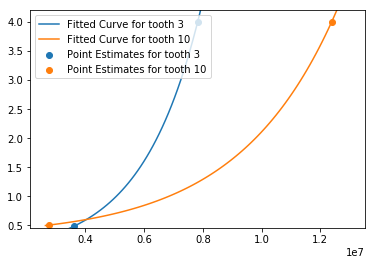

,0.0,1000000.0,1555555.5555555555,2111111.111111111,2666666.6666666665,3222222.222222222,3777777.7777777775,4333333.333333333,4888888.888888888,5444444.444444444,6000000.0
0,-0.850692,-0.549903,-0.382798,-0.215693,-0.048588,0.118517,0.285623,0.452728,0.619833,0.786938,0.954043
1,-0.288954,-0.200298,-0.151045,-0.101792,-0.052539,-0.003286,0.045967,0.095220,0.144473,0.193727,0.242980


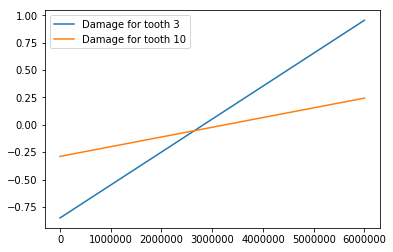

,0.0,1000000.0,1555555.5555555555,2111111.111111111,2666666.6666666665,3222222.222222222,3777777.7777777775,4333333.333333333,4888888.888888888,5444444.444444444,6000000.0
0,NaN,NaN,NaN,NaN,NaN,[0.6210133544907638],[0.8840107865350099],[1.2583869011175495],[1.7913102611689857],[2.5499251851077256],[3.62981142384763]
1,NaN,NaN,NaN,NaN,NaN,NaN,[0.5365756034552143],[0.5726613981684502],[0.6142514991629224],[0.6621854996325296],[0.7174310591786749]


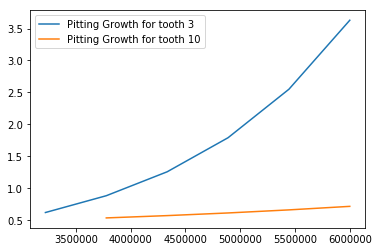

,a0,n0,tooth,neol,aeol,theta1,theta2,theta3,n0_old,neol_old
0,1.191385,8.079540e+06,2,1.312922e+07,4.0,0.0701,3.000000e-07,4.000000e-01,5.121978e+06,1.316074e+07
1,0.172684,5.677857e+06,11,1.196303e+07,4.0,0.0101,5.000000e-07,1.776357e-15,5.283728e+06,1.211617e+07
2,0.507219,7.752732e+06,12,1.165697e+07,4.0,0.0001,9.000000e-07,4.000000e-01,5.842420e+06,1.157680e+07


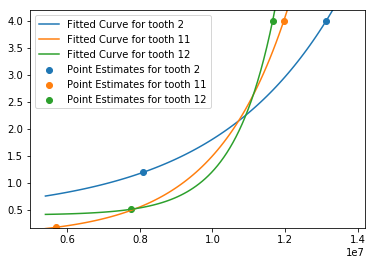

,0.0,1000000.0,1555555.5555555555,2111111.111111111,2666666.6666666665,3222222.222222222,3777777.7777777775,4333333.333333333,4888888.888888888,5444444.444444444,6000000.0
0,-1.600010,-1.399197,-1.287635,-1.176072,-1.064510,-0.952947,-0.841385,-0.729822,-0.618260,-0.506697,-0.395134
1,-0.903374,-0.741989,-0.652331,-0.562673,-0.473015,-0.383357,-0.293699,-0.204041,-0.114383,-0.024725,0.064933
2,-1.985721,-1.725703,-1.581248,-1.436793,-1.292338,-1.147884,-1.003429,-0.858974,-0.714520,-0.570065,-0.425610


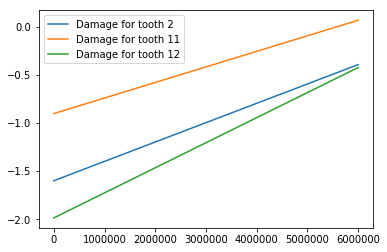

,0.0,1000000.0,1555555.5555555555,2111111.111111111,2666666.6666666665,3222222.222222222,3777777.7777777775,4333333.333333333,4888888.888888888,5444444.444444444,6000000.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[0.21177438791036585]
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


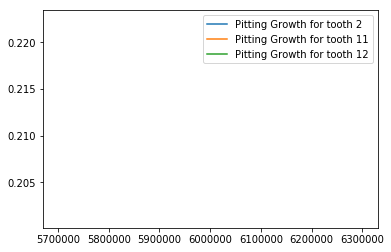

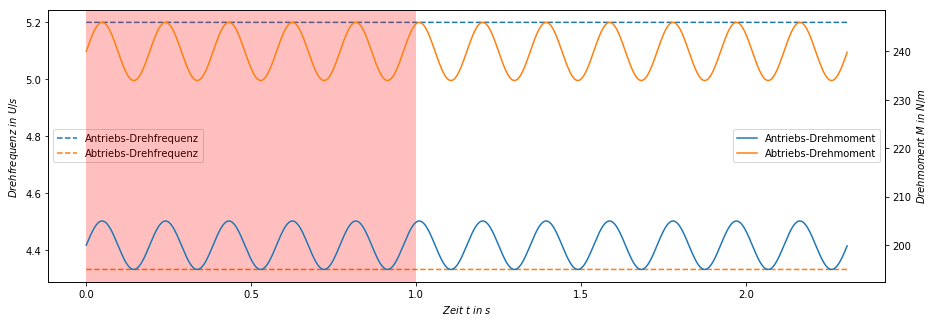

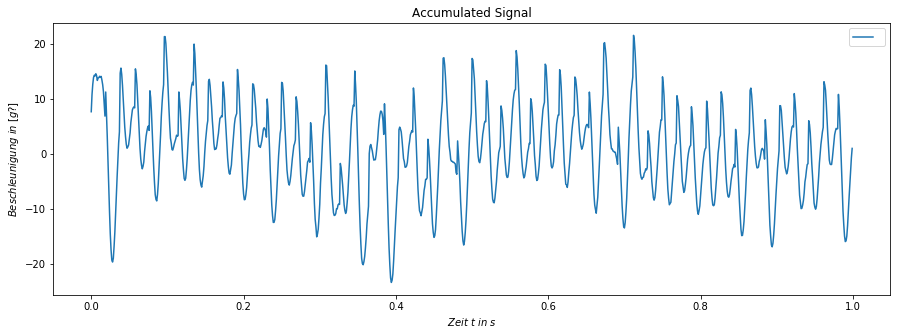

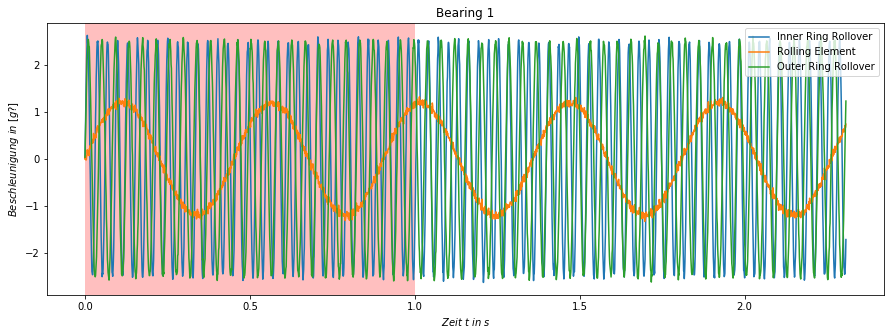

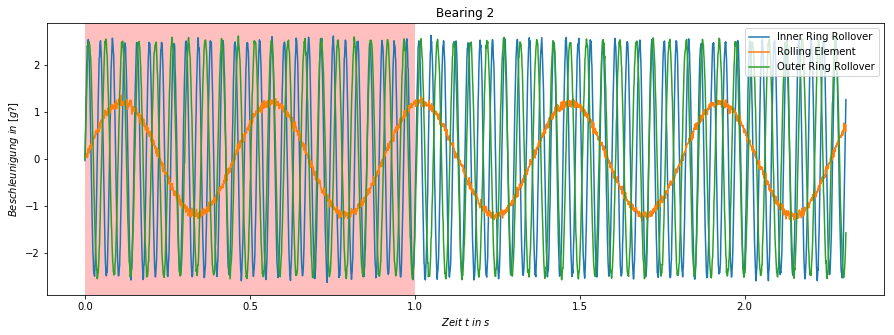

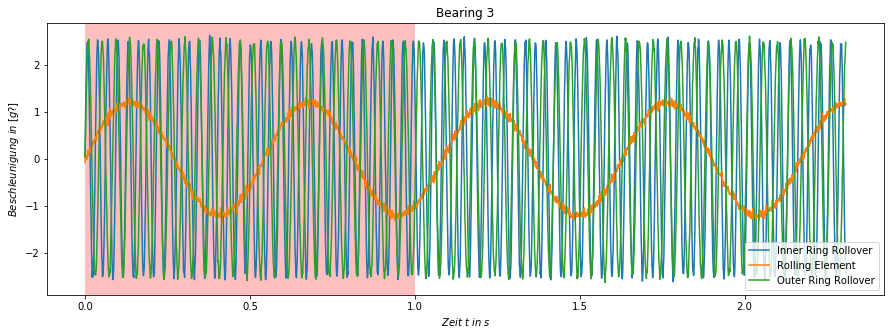

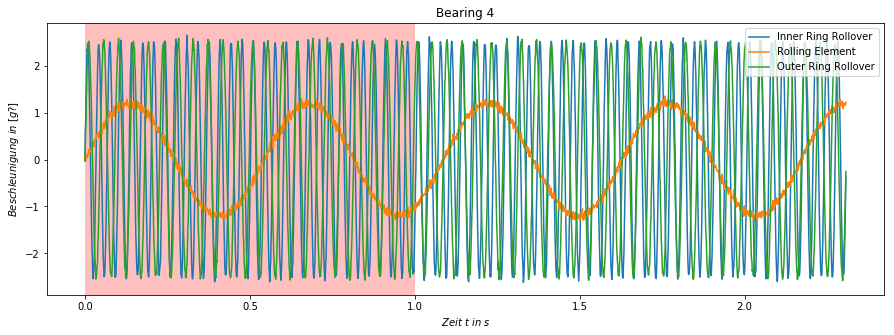

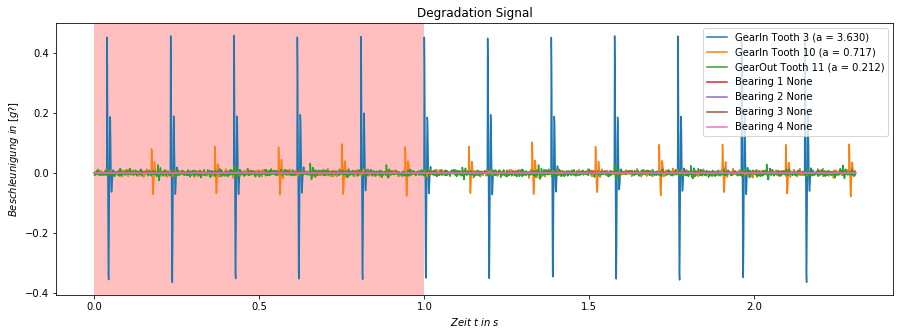

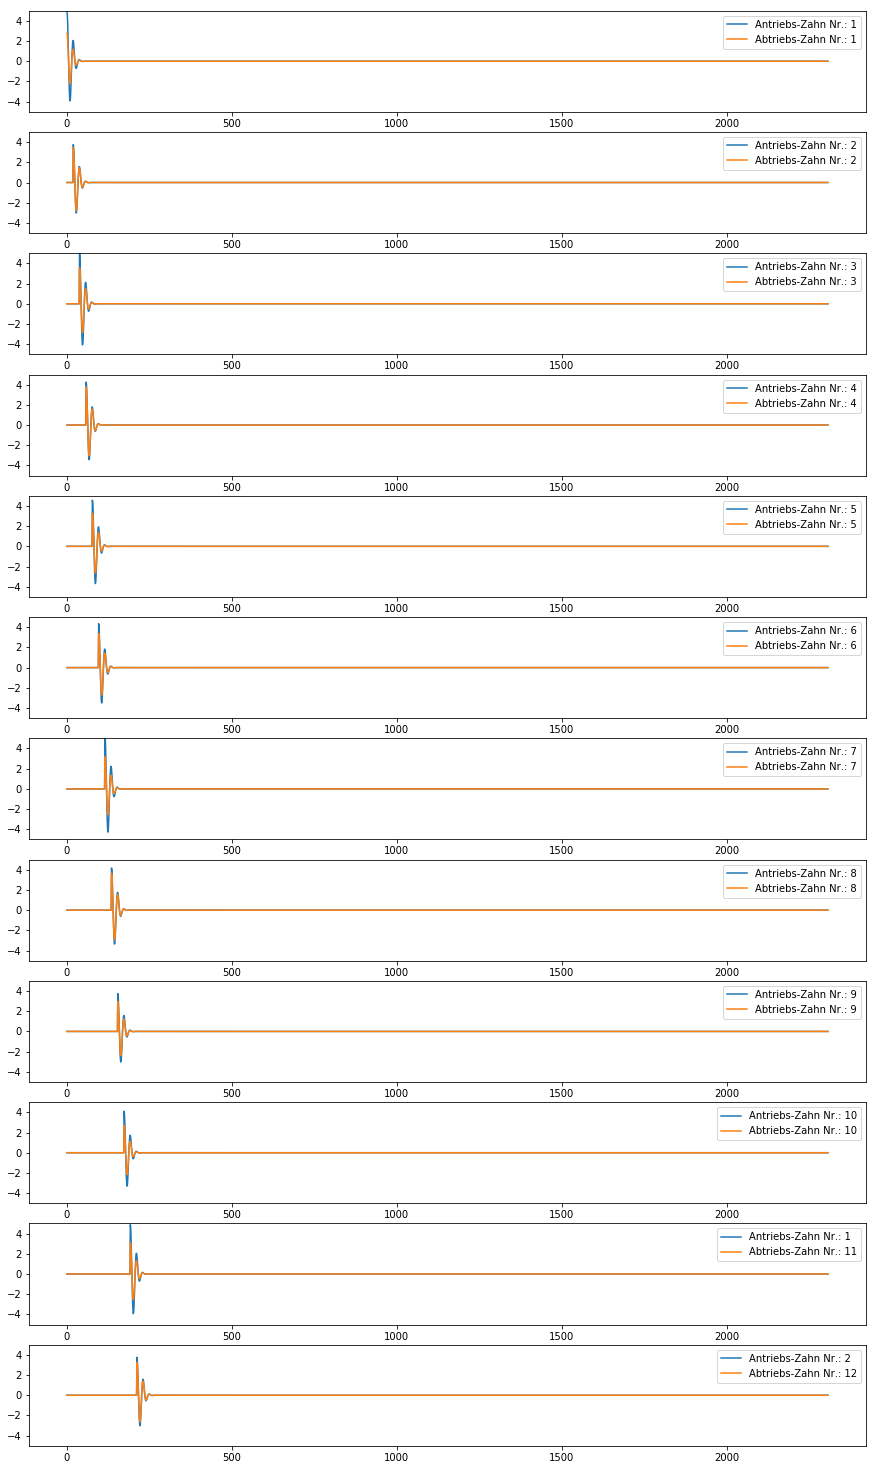

In [33]:
model.summary()

In [34]:
#%% Parameter Pipeline
alpha = 0.01 #tukey window parameter
sample_rate = 51200 #fft parameter
pp = 40 #pooling_parameter - window size
yf, xf = gf.rfft_y(vibration, alpha, sample_rate, pp, scale=False)

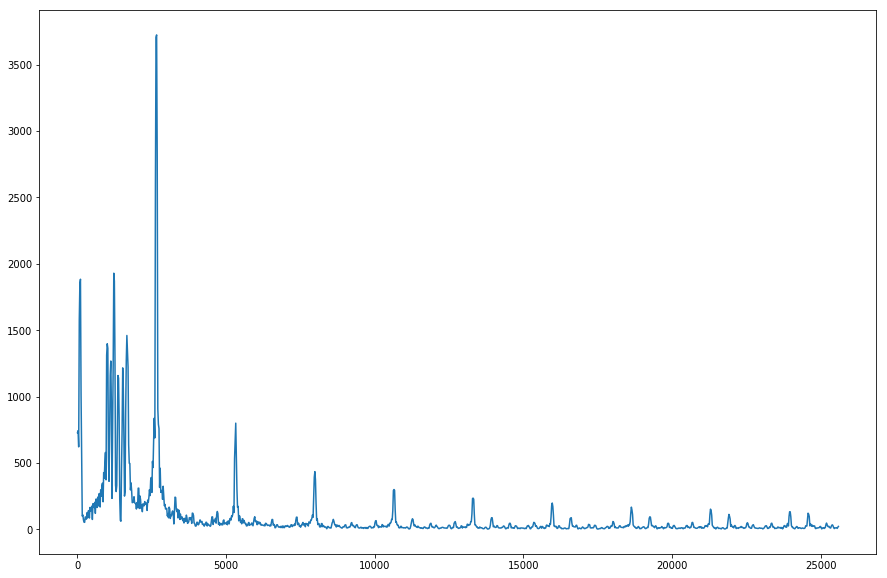

In [35]:
plt.figure(figsize=[15,10])
plt.plot(xf, yf)